In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from lmfit import Model

#matplotlib.rcParams.keys()
mpl.rcParams['figure.figsize'] = (11, 7)
mpl.rc('font', size=14)
COLOR = 'grey'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
length = 8
width = 1.5
mpl.rcParams['xtick.major.size'] = length
mpl.rcParams['ytick.major.size'] = length
mpl.rcParams['xtick.major.width'] = width
mpl.rcParams['ytick.major.width'] = width

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.2.9-py3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# XPCS spot size

In [3]:
def speckle_size(lam, footprint, L):
    return lam*L/footprint

display = 'plott'

lam = 0.15E-3 # [um]
iangle = np.deg2rad(90)
spot_size = np.arange(5,20,1)  # [um]
footprint = spot_size/np.sin(iangle)
L = 3.5E6 # [um]

S = speckle_size(lam, footprint, L)
if display=='print':
    if S.ndim!=1:
        S = np.asarray([S])
    st = 'Speckle size: ' + ', '.join('{:0.2f}'.format(k) for k in S) + ' [um]'
    print(st)
elif display=='plot':
    x = np.argmax([np.array([lam]).size, np.array([footprint]).size, np.array([L]).size])
    if x==0:
        x = lam*1000
        xlabel = 'Wavelength [nm]'
    elif x==1:
        x = footprint
        xlabel = 'Footprint size [um]'
    elif x==2:
        x = L*10**-6
        xlabel = 'Samplt - det distance [m]'
    ax = plt.subplot(1,1,1)
    ax.plot(x,S,'-o')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Speckel size [um]')
    plt.show()    

Speckle size: 105.00, 87.50, 75.00, 65.62, 58.33, 52.50, 47.73, 43.75, 40.38, 37.50, 35.00, 32.81, 30.88, 29.17, 27.63 [um]


# Optical properties


Penetration depth 1/alpha = 64.46 [nm]


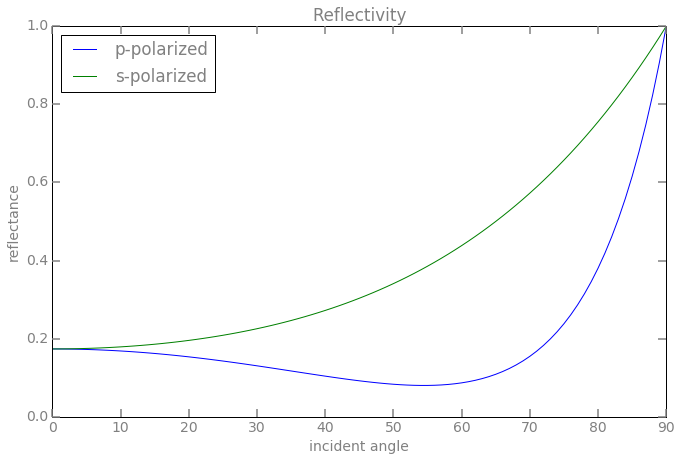

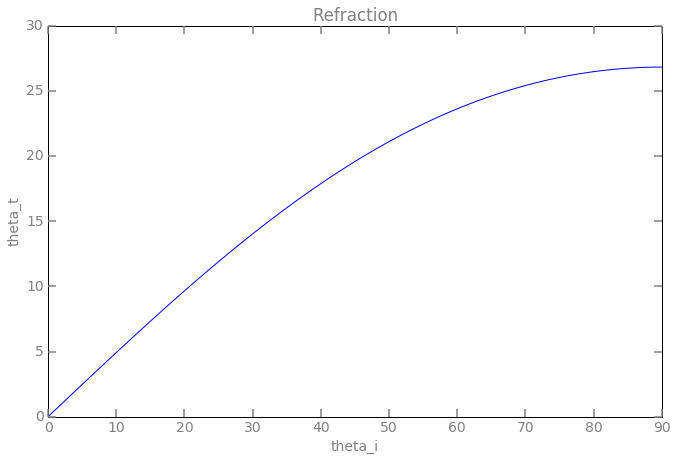

In [5]:
""" CONSTANTS """
e_0 = 8.85E-12; # [s/(Ohm*m)]
c = 299792458; # [m/s]

""" MATERIAL AND LIGHT DATA """
sigma = 500 # [1/(Ohm*cm)]
sigma = sigma*100 # [1/(Ohm*m)]
e_r = 0.5 # [] real part of epsilon
wvl = 800E-9 # [m] wavelength
f = c/wvl # [1/s]
omega = 2*np.pi*f # [1/s]

"""#########################################################################"""
n = np.sqrt(e_r+1j*sigma/e_0/omega)
alpha = 2*n.imag*omega/c

str = '\nPenetration depth 1/alpha = {:0.2f} [nm]'.format((1/alpha)*10**9)
print(str)

""" REFLECTIVITY """
nr = n.real;
ni = n.imag;
thetai = np.deg2rad(np.arange(0,91,1))
thetat = np.arcsin( np.sin(thetai)/n )

r = (np.cos(thetai)-n*np.cos(thetat)) / (np.cos(thetai)+n*np.cos(thetat))
R = np.absolute( r )**2 # reflectivity at incident angle theta1 (s-pol)
R_N = ( 1-n / (1+n) )**2 # normal incidence reflectivity

""" p-polarized light """
num = -( (nr**2-ni**2+1j*(2*nr*ni)) )*np.cos(thetai) + np.sqrt( (nr**2-ni**2-np.sin(thetai)**2+1j*2*nr*ni) )
den = ( (nr**2-ni**2+1j*(2*nr*ni)) )*np.cos(thetai) + np.sqrt( (nr**2-ni**2-np.sin(thetai)**2+1j*2*nr*ni) )
R_p = np.absolute(num / den)**2

""" s-polarized light """
num = np.cos(thetai) - np.sqrt( (nr**2-ni**2-np.sin(thetai)**2+1j*2*nr*ni) )
den = np.cos(thetai) + np.sqrt( (nr**2-ni**2-np.sin(thetai)**2+1j*2*nr*ni) )
R_s = np.absolute(num / den)**2

thetai = np.rad2deg(thetai)
thetat = np.rad2deg(thetat.real)
plt.figure('Reflectivity')
plt.title('Reflectivity')
plt.plot(thetai, R_p, label='p-polarized')
plt.xlabel('incident angle')
plt.ylabel('reflectance')
plt.plot(thetai, R_s, label='s-polarized')
plt.xlabel('incident angle')
plt.ylabel('reflectance')
plt.legend(loc='upper left')

plt.figure('Refraction')
plt.title('Refraction')
plt.plot(thetai, thetat)
plt.xlabel('theta_i')
plt.ylabel('theta_t')
plt.show()

# Fluence

In [8]:
""" material properties """
""" low T """
z0 = 52 # effective penetration depth [nm]
T = 0.8 # transmission
Cp = 5 # heat capacity [J/K(/mol)]
""" high T """
z0 = 64
T = 0.82
Cp = 10

""" laser properties """
power = 5 # [mW]
rep_rate = 1000 # [Hz]
spotx = 0.046 # FWHM [cm]
spoty = 0.052 # FWHM [cm]
err_spot = 0.001 # [cm]

""" fluence """
fluence = power/rep_rate/spotx/spoty # [mJ/cm^2]
fluence_max = power/rep_rate/(spotx-err_spot)/(spoty-err_spot)
fluence_min = power/rep_rate/(spotx+err_spot)/(spoty+err_spot)
print('\nfluence = {:0.2f} ({:1.2f}, {:2.2f}) mJ/cm^2'.format(fluence, fluence_min-fluence, fluence_max-fluence))

""" energy density """
dlayer = 1 # [nm]
flu_top = fluence*T*np.exp(-0*dlayer/z0)
flu_bottom = fluence*T*np.exp(-1*dlayer/z0)
n0 = (flu_top-flu_bottom)/(dlayer*1E-7)/1000

flu_top = fluence_max*T*np.exp(-0*dlayer/z0)
flu_bottom = fluence_max*T*np.exp(-1*dlayer/z0)
n0_max = (flu_top-flu_bottom)/(dlayer*1E-7)/1000

flu_top = fluence_min*T*np.exp(-0*dlayer/z0)
flu_bottom = fluence_min*T*np.exp(-1*dlayer/z0)
n0_min = (flu_top-flu_bottom)/(dlayer*1E-7)/1000
print('\nn = {:0.2f} ({:1.2f}, {:2.2f}) mJ/cm^2'.format(n0, n0_min-n0, n0_max-n0))


""" Average heating """
heating = power/rep_rate/Cp*T *1000 #[mK]
print('\nheating = {:0.3f} K'.format(heating))


fluence = 2.09 (-0.08, 0.09) mJ/cm^2

 n = 265.74 (-10.56, 11.23) mJ/cm^2

 heating = 0.410 K
